## QM Workflow with QM7 example

In [1]:
import keras as ks

just for downloading the some data in place of your data.

In [2]:
%%capture
from kgcnn.data.datasets.QM7Dataset import QM7Dataset
QM7Dataset()

move the data from "~/.kgcnn.datasets.qm7" to your local "qm7" folder. The QM7 data is just some example data for this notebook.

In [3]:
from kgcnn.data.qm import QMDataset

In [4]:
data = QMDataset(
    data_directory="qm7/",
    dataset_name="qm7",
    file_name="qm7.csv",
    file_name_xyz="qm7.xyz"
)

In [5]:
data.prepare_data(
    overwrite=True,
    file_column_name=None,
    make_sdf=True
);

In [6]:
%%capture
from kgcnn.molecule.encoder import OneHotEncoder
data.read_in_memory(
    nodes = [
        'Symbol', 'TotalDegree', 'FormalCharge', 'NumRadicalElectrons', 'Hybridization',
        'IsAromatic', 'IsInRing', 'TotalNumHs', 'CIPCode', "ChiralityPossible", "ChiralTag"
    ],
    encoder_nodes = {
        'Symbol': OneHotEncoder(
            ['B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'As', 'Se', 'Br', 'Te', 'I', 'At'],
            dtype="str"
        ),
        'Hybridization': OneHotEncoder([2, 3, 4, 5, 6]),
        'TotalDegree': OneHotEncoder([0, 1, 2, 3, 4, 5], add_unknown=False),
        'TotalNumHs': OneHotEncoder([0, 1, 2, 3, 4], add_unknown=False),
        'CIPCode': OneHotEncoder(['R', 'S'], add_unknown=False, dtype='str'),
        "ChiralityPossible": OneHotEncoder(["1"], add_unknown=False, dtype='str'),
    },
    edges = ['BondType', 'IsAromatic', 'IsConjugated', 'IsInRing', 'Stereo'],
    encoder_edges = {
        'BondType': OneHotEncoder([1, 2, 3, 12], add_unknown=False),
        'Stereo': OneHotEncoder([0, 1, 2, 3], add_unknown=False)
    },
    graph=['ExactMolWt', 'NumAtoms'],
    encoder_graph = {},
    
    add_hydrogen=True,
    make_directed=False,
    sanitize=False,
    compute_partial_charges=None,
    label_column_name="u0_atom"
)

In [7]:
from kgcnn.graph.preprocessor import SetRange
data.map_list(SetRange(max_distance=5.0, in_place=True));
data.map_list(method="count_nodes_and_edges", total_edges="total_ranges", count_edges="range_indices", 
    count_nodes="node_number", total_nodes="total_nodes");

In [8]:
print(data[0])

{'node_symbol': array(['C', 'H', 'H', 'H', 'H'], dtype='<U1'), 'node_number': array([6, 1, 1, 1, 1]), 'node_coordinates': array([[ 0.9983, -0.0025, -0.0044],
       [ 2.0902, -0.0024,  0.0041],
       [ 0.6338,  1.0269,  0.0041],
       [ 0.627 , -0.5277,  0.8781],
       [ 0.6414, -0.5075, -0.9054]]), 'edge_indices': array([[0, 1],
       [0, 2],
       [0, 3],
       [0, 4],
       [1, 0],
       [2, 0],
       [3, 0],
       [4, 0]], dtype=int64), 'edge_number': array([1, 1, 1, 1, 1, 1, 1, 1]), 'graph_labels': array(-417.96), 'node_attributes': array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 2.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [9]:
import numpy as np
labels = np.array(data.obtain_property("graph_labels"))
if len(labels.shape) <= 1:
    labels = np.expand_dims(labels, axis=-1)

In [10]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=42, shuffle=True)
train_test_indices = [
    [train_index, test_index] for train_index, test_index in kf.split(X=np.zeros((len(data), 1)), y=labels)]

In [11]:
model_config= {
    "class_name": "make_model",
    "module_name": "kgcnn.literature.Schnet",
    "config": {
        "name": "Schnet",
        "inputs": [
            {"shape": [None], "name": "node_number", "dtype": "int32"},
            {"shape": [None, 3], "name": "node_coordinates", "dtype": "float32"},
            {"shape": [None, 2], "name": "range_indices", "dtype": "int64"},
            {"shape": (), "name": "total_nodes", "dtype": "int64"},
            {"shape": (), "name": "total_ranges", "dtype": "int64"}
        ],
        "cast_disjoint_kwargs": {"padded_disjoint": False},
        "input_node_embedding": {"input_dim": 95, "output_dim": 64},
        "last_mlp": {"use_bias": [True, True, True], "units": [128, 64, 1],
                     "activation": ['kgcnn>shifted_softplus', 'kgcnn>shifted_softplus', 'linear']},
        "interaction_args": {
            "units": 128, "use_bias": True, "activation": "kgcnn>shifted_softplus", "cfconv_pool": "scatter_sum"
        },
        "node_pooling_args": {"pooling_method": "scatter_sum"},
        "depth": 4,
        "gauss_args": {"bins": 20, "distance": 4, "offset": 0.0, "sigma": 0.4}, "verbose": 10,
        "output_embedding": "graph",
        "use_output_mlp": False,
        "output_mlp": None,
    }
}

In [12]:
import time
from kgcnn.models.utils import get_model_class
from keras.optimizers import Adam
from kgcnn.training.scheduler import LinearLearningRateScheduler
from kgcnn.literature.Schnet import make_model
from kgcnn.data.transform.scaler.molecule import QMGraphLabelScaler
from kgcnn.data.transform.scaler.standard import StandardLabelScaler
from kgcnn.metrics.metrics import ScaledMeanAbsoluteError, ScaledRootMeanSquaredError
from datetime import timedelta

history_list, test_indices_list = [], []
model, hist, x_test, y_test, scaler, atoms_test = None, None, None, None, None, None
splits_done = 0
for i, (train_index, test_index) in enumerate(train_test_indices):
    print("Running training on fold: %s" % i)

    # Make the model for current split using model kwargs from hyperparameter.
    # They are always updated on top of the models default kwargs.
    model = make_model(**model_config["config"])

    # First select training and test graphs from indices, then convert them into tensorflow tensor
    # representation. Which property of the dataset and whether the tensor will be ragged is retrieved from the
    # kwargs of the keras `Input` layers ('name' and 'ragged').
    dataset_train, dataset_test = data[train_index], data[test_index]
    x_train, y_train = dataset_train.tensor(model_config["config"]["inputs"]), labels[train_index]
    x_test, y_test = dataset_test.tensor(model_config["config"]["inputs"]), labels[test_index]
    
    atoms_test = dataset_test.get("node_number")
    atoms_train = dataset_train.get("node_number")
    
    scaler = QMGraphLabelScaler([StandardLabelScaler(with_std=True, with_mean=True, copy=True)])
    scaler.fit(y=y_train, atomic_number=atoms_train)
    y_train = scaler.transform(y=y_train, atomic_number=atoms_train)
    y_test = scaler.transform(y=y_test, atomic_number=atoms_test)

    # If scaler was used we add rescaled standard metrics to compile.
    scaler_scale = scaler.get_scaling()
    mae_metric = ScaledMeanAbsoluteError(scaler_scale.shape, name="scaled_mean_absolute_error")
    rms_metric = ScaledRootMeanSquaredError(scaler_scale.shape, name="scaled_root_mean_squared_error")
    if scaler.scale_ is not None:
        mae_metric.set_scale(scaler_scale)
        rms_metric.set_scale(scaler_scale)
    metrics = [mae_metric, rms_metric]

    # Compile model with optimizer and loss
    model.compile(loss="mean_absolute_error", metrics=metrics, optimizer=Adam(learning_rate=5e-04))
    model.summary()
    print(" Compiled with jit: %s" % model._jit_compile)  # noqa

    # Start and time training
    start = time.process_time()
    hist = model.fit(x_train, y_train,
                     validation_data=(x_test, y_test),
                     batch_size=32, 
                     epochs=800, 
                     validation_freq=10, 
                     # Change to verbose = 2 to see progress
                     verbose=0,
                     callbacks= [
                         LinearLearningRateScheduler(
                             learning_rate_start=0.0005, learning_rate_stop=1e-05, epo_min=100, epo=800)
                     ])
    stop = time.process_time()
    print("Print Time for training: ", str(timedelta(seconds=stop - start)))

    # Get loss from history
    history_list.append(hist)
    test_indices_list.append([train_index, test_index])
    splits_done = splits_done + 1

Running training on fold: 0


Model: "Schnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ node_number (InputLayer)      │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ range_indices (InputLayer)    │ (None, None, 2)           │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ total_nodes (InputLayer)      │ (None)                    │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ total_ranges (InputLayer)     │ (None)                    │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ node_coordinates (InputLayer) │ (None, None, 3)           │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ cast_batched_indices_to_disj… │ [(None), (2, None),       │           0 │ node_number[0][0],             │
│ (CastBatchedIndicesToDisjoin… │ (None), (None), (None),   │             │ range_indices[0][0],           │
│                               │ (None), (None), (None)]   │             │ total_nodes[0][0],             │
│                               │                           │             │ total_ranges[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ cast_batched_attributes_to_d… │ [(None, 3), (None),       │           0 │ node_coordinates[0][0],        │
│ (CastBatchedAttributesToDisj… │ (None), (None)]           │             │ total_nodes[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ cast_batched_attributes_to_d… │ [(None), (None), (None),  │           0 │ node_number[0][0],             │
│ (CastBatchedAttributesToDisj… │ (None)]                   │             │ total_nodes[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ node_position (NodePosition)  │ [(None, 3), (None, 3)]    │           0 │ cast_batched_attributes_to_di… │
│                               │                           │             │ cast_batched_indices_to_disjo… │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ embedding (Embedding)         │ (None, 64)                │       6,080 │ cast_batched_attributes_to_di… │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ node_distance_euclidean       │ (None, 1)                 │           0 │ node_position[0][0],           │
│ (NodeDistanceEuclidean)       │                           │             │ node_position[0][1]            │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │       8,320 │ embedding[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ gauss_basis_layer             │ (None, 20)                │           0 │ node_distance_euclidean[0][0]  │
│ (GaussBasisLayer)             │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼─

 Total params: 313,665 (1.20 MB)

 Trainable params: 313,665 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Compiled with jit: False
Print Time for training:  1:46:01.859375
Running training on fold: 1


Model: "Schnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ node_number (InputLayer)      │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ range_indices (InputLayer)    │ (None, None, 2)           │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ total_nodes (InputLayer)      │ (None)                    │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ total_ranges (InputLayer)     │ (None)                    │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ node_coordinates (InputLayer) │ (None, None, 3)           │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ cast_batched_indices_to_disj… │ [(None), (2, None),       │           0 │ node_number[0][0],             │
│ (CastBatchedIndicesToDisjoin… │ (None), (None), (None),   │             │ range_indices[0][0],           │
│                               │ (None), (None), (None)]   │             │ total_nodes[0][0],             │
│                               │                           │             │ total_ranges[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ cast_batched_attributes_to_d… │ [(None, 3), (None),       │           0 │ node_coordinates[0][0],        │
│ (CastBatchedAttributesToDisj… │ (None), (None)]           │             │ total_nodes[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ cast_batched_attributes_to_d… │ [(None), (None), (None),  │           0 │ node_number[0][0],             │
│ (CastBatchedAttributesToDisj… │ (None)]                   │             │ total_nodes[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ node_position_1               │ [(None, 3), (None, 3)]    │           0 │ cast_batched_attributes_to_di… │
│ (NodePosition)                │                           │             │ cast_batched_indices_to_disjo… │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 64)                │       6,080 │ cast_batched_attributes_to_di… │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ node_distance_euclidean_1     │ (None, 1)                 │           0 │ node_position_1[0][0],         │
│ (NodeDistanceEuclidean)       │                           │             │ node_position_1[0][1]          │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ dense_21 (Dense)              │ (None, 128)               │       8,320 │ embedding_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ gauss_basis_layer_1           │ (None, 20)                │           0 │ node_distance_euclidean_1[0][… │
│ (GaussBasisLayer)             │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼─

 Total params: 313,665 (1.20 MB)

 Trainable params: 313,665 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Compiled with jit: False
Print Time for training:  1:44:55.859375
Running training on fold: 2


Model: "Schnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ node_number (InputLayer)      │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ range_indices (InputLayer)    │ (None, None, 2)           │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ total_nodes (InputLayer)      │ (None)                    │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ total_ranges (InputLayer)     │ (None)                    │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ node_coordinates (InputLayer) │ (None, None, 3)           │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ cast_batched_indices_to_disj… │ [(None), (2, None),       │           0 │ node_number[0][0],             │
│ (CastBatchedIndicesToDisjoin… │ (None), (None), (None),   │             │ range_indices[0][0],           │
│                               │ (None), (None), (None)]   │             │ total_nodes[0][0],             │
│                               │                           │             │ total_ranges[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ cast_batched_attributes_to_d… │ [(None, 3), (None),       │           0 │ node_coordinates[0][0],        │
│ (CastBatchedAttributesToDisj… │ (None), (None)]           │             │ total_nodes[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ cast_batched_attributes_to_d… │ [(None), (None), (None),  │           0 │ node_number[0][0],             │
│ (CastBatchedAttributesToDisj… │ (None)]                   │             │ total_nodes[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ node_position_2               │ [(None, 3), (None, 3)]    │           0 │ cast_batched_attributes_to_di… │
│ (NodePosition)                │                           │             │ cast_batched_indices_to_disjo… │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ embedding_2 (Embedding)       │ (None, 64)                │       6,080 │ cast_batched_attributes_to_di… │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ node_distance_euclidean_2     │ (None, 1)                 │           0 │ node_position_2[0][0],         │
│ (NodeDistanceEuclidean)       │                           │             │ node_position_2[0][1]          │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ dense_42 (Dense)              │ (None, 128)               │       8,320 │ embedding_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ gauss_basis_layer_2           │ (None, 20)                │           0 │ node_distance_euclidean_2[0][… │
│ (GaussBasisLayer)             │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼─

 Total params: 313,665 (1.20 MB)

 Trainable params: 313,665 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Compiled with jit: False
Print Time for training:  1:45:27.593750
Running training on fold: 3


Model: "Schnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ node_number (InputLayer)      │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ range_indices (InputLayer)    │ (None, None, 2)           │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ total_nodes (InputLayer)      │ (None)                    │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ total_ranges (InputLayer)     │ (None)                    │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ node_coordinates (InputLayer) │ (None, None, 3)           │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ cast_batched_indices_to_disj… │ [(None), (2, None),       │           0 │ node_number[0][0],             │
│ (CastBatchedIndicesToDisjoin… │ (None), (None), (None),   │             │ range_indices[0][0],           │
│                               │ (None), (None), (None)]   │             │ total_nodes[0][0],             │
│                               │                           │             │ total_ranges[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ cast_batched_attributes_to_d… │ [(None, 3), (None),       │           0 │ node_coordinates[0][0],        │
│ (CastBatchedAttributesToDisj… │ (None), (None)]           │             │ total_nodes[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ cast_batched_attributes_to_d… │ [(None), (None), (None),  │           0 │ node_number[0][0],             │
│ (CastBatchedAttributesToDisj… │ (None)]                   │             │ total_nodes[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ node_position_3               │ [(None, 3), (None, 3)]    │           0 │ cast_batched_attributes_to_di… │
│ (NodePosition)                │                           │             │ cast_batched_indices_to_disjo… │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ embedding_3 (Embedding)       │ (None, 64)                │       6,080 │ cast_batched_attributes_to_di… │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ node_distance_euclidean_3     │ (None, 1)                 │           0 │ node_position_3[0][0],         │
│ (NodeDistanceEuclidean)       │                           │             │ node_position_3[0][1]          │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ dense_63 (Dense)              │ (None, 128)               │       8,320 │ embedding_3[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ gauss_basis_layer_3           │ (None, 20)                │           0 │ node_distance_euclidean_3[0][… │
│ (GaussBasisLayer)             │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼─

 Total params: 313,665 (1.20 MB)

 Trainable params: 313,665 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Compiled with jit: False
Print Time for training:  1:45:28.109375
Running training on fold: 4


Model: "Schnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ node_number (InputLayer)      │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ range_indices (InputLayer)    │ (None, None, 2)           │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ total_nodes (InputLayer)      │ (None)                    │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ total_ranges (InputLayer)     │ (None)                    │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ node_coordinates (InputLayer) │ (None, None, 3)           │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ cast_batched_indices_to_disj… │ [(None), (2, None),       │           0 │ node_number[0][0],             │
│ (CastBatchedIndicesToDisjoin… │ (None), (None), (None),   │             │ range_indices[0][0],           │
│                               │ (None), (None), (None)]   │             │ total_nodes[0][0],             │
│                               │                           │             │ total_ranges[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ cast_batched_attributes_to_d… │ [(None, 3), (None),       │           0 │ node_coordinates[0][0],        │
│ (CastBatchedAttributesToDisj… │ (None), (None)]           │             │ total_nodes[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ cast_batched_attributes_to_d… │ [(None), (None), (None),  │           0 │ node_number[0][0],             │
│ (CastBatchedAttributesToDisj… │ (None)]                   │             │ total_nodes[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ node_position_4               │ [(None, 3), (None, 3)]    │           0 │ cast_batched_attributes_to_di… │
│ (NodePosition)                │                           │             │ cast_batched_indices_to_disjo… │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ embedding_4 (Embedding)       │ (None, 64)                │       6,080 │ cast_batched_attributes_to_di… │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ node_distance_euclidean_4     │ (None, 1)                 │           0 │ node_position_4[0][0],         │
│ (NodeDistanceEuclidean)       │                           │             │ node_position_4[0][1]          │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ dense_84 (Dense)              │ (None, 128)               │       8,320 │ embedding_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ gauss_basis_layer_4           │ (None, 20)                │           0 │ node_distance_euclidean_4[0][… │
│ (GaussBasisLayer)             │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼─

 Total params: 313,665 (1.20 MB)

 Trainable params: 313,665 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Compiled with jit: False
Print Time for training:  1:45:01.765625


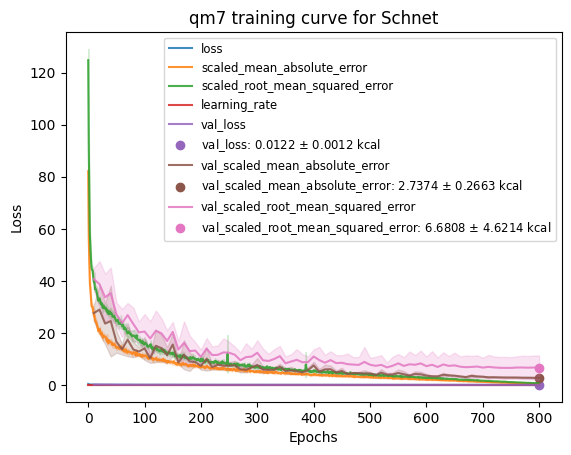

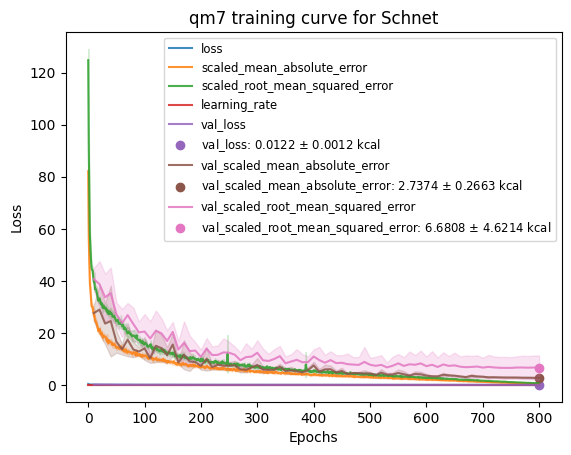

In [13]:
from kgcnn.utils.plots import plot_train_test_loss, plot_predict_true

plot_train_test_loss(history_list, loss_name=None, val_loss_name=None,
                     model_name="Schnet", data_unit="kcal", dataset_name="qm7",
                     filepath="", file_name=f"loss.png")